In [69]:
# Import necessary packages
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from numpy import random
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
%run optimization_functions.ipynb

# Get dual graph
#stl = nx.read_weighted_edgelist(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\weighted_dual_list",delimiter='%',nodetype=str)
stl = nx.read_weighted_edgelist("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data pulling code/weighted_dual_list",delimiter='%',nodetype=str)


# get population data and set node attributes
#centroid_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\CensusTractCentroids.csv")
#metro_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_REGISTERED.csv")
#north_south_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_NS.csv")
#census_data = data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08119_stl_city.csv")
#race_data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08105_stl_city.csv")

centroid_locations = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/CensusTractCentroids.csv")
metro_locations = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/MetroLinkStations_NS.csv")
census_data = data = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/B08119_stl_city.csv")
race_data = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/data/B08105_stl_city.csv")

# clean data 
def clean(census_data, race_data):
    import warnings
    import numpy as np
    # clean census data
    warnings. filterwarnings('ignore')

    # Only keep important columns
    census_data = census_data[['location','label','estimate','moe']]
    census_data['label'] = census_data['label'].str.replace('Estimate', '').str.replace('Total', '').str.replace('!!', '').str.replace(':', '')
    census_data['location'] = census_data['location'].str.replace('; St. Louis city; Missouri','')

    # Filter out aggregate columns
    all_totals = census_data[census_data['label']=='']
    total_tract_pops = np.array(all_totals['estimate'].tolist())
    tract_pop_proportions = total_tract_pops / np.sum(total_tract_pops)
    trans_totals_mask = ~census_data['label'].astype(str).str.contains('[$]')
    trans_totals = census_data.loc[trans_totals_mask][1:]
    income_totals = census_data[census_data['label'].str.startswith("$")]
    not_to_include = pd.concat([trans_totals, income_totals, all_totals])
    merged_df = pd.merge(census_data, not_to_include, how='left', indicator=True)
    no_totals = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])[1:]
    split_data = no_totals['label'].str.split('$', n=1, expand=True)
    no_totals[['transportation', 'income']] = split_data
    no_totals.drop(columns=['label'], inplace=True)
    no_totals['income'] = '$' + no_totals['income']
    from_this = no_totals['income'].unique()
    to_this = [1, 10000, 15000, 25000, 35000, 50000, 65000, 75000]
    no_totals['avg income'] = no_totals['income'].replace(from_this, to_this)
    clean_census_data = no_totals
    
    # clean race data
    # Only keep important columns
    race_data = race_data[['location','label','concept','estimate','moe']]
    race_data['label'] = race_data['label'].str.replace('Estimate', '').str.replace('Total', '').str.replace('!!', '').str.replace(':', '')
    race_data['location'] = race_data['location'].str.replace('; St. Louis city; Missouri','')
    race_data['concept'] = race_data['concept'].str.replace('MEANS OF TRANSPORTATION TO WORK ', '').str.replace(')','').str.replace('(','').str.replace('ALONE','')

    # Filter out aggregate rows and rename columns
    race_data = race_data[race_data['label'] != '']
    race_data = race_data.rename(columns={'label': 'transportation', 'concept': 'race'})
    
    # Group by census tract and mode of transportation
    by_tract_trans = clean_census_data.groupby(['location','transportation'])['estimate'].sum()

    # Find percentage of people who take public transport in each tract
    tract_pops = clean_census_data.groupby('location', as_index = False)['estimate'].sum()['estimate'].tolist()
    public_transit_pops = clean_census_data[clean_census_data['transportation']=='Public transportation (excluding taxicab)'].groupby(['location','transportation'], as_index = False)['estimate'].sum()['estimate'].tolist()
    total_public_transit_pops = sum(public_transit_pops)

    # Add percentages back in to groupby
    by_tract = clean_census_data.groupby('location', as_index = False)['estimate'].sum()
    by_tract['transit weight'] = np.array(public_transit_pops) / total_public_transit_pops
    by_tract['transit weight (pop)'] = np.divide(by_tract['transit weight'],tract_pop_proportions)
    
    # Group by census tract and income
    by_tract_inc = clean_census_data.groupby(['location','avg income'])['estimate'].sum()

    # Find average income of each tract
    tract_incomes = (clean_census_data['avg income']*clean_census_data['estimate']).groupby(clean_census_data['location']).sum().tolist()
    tract_totals = sum(tract_incomes)
    tract_incomes_new = np.array([tract_totals - i for i in tract_incomes])
    income_weight = tract_incomes_new / sum(tract_incomes_new)

    # Add percentages back in to groupby
    by_tract['income weight'] = income_weight
    by_tract['income weight (pop)'] = np.divide(by_tract['income weight'],tract_pop_proportions)
    
    # Find minority (nonwhite) population of each tract
    total_pops = race_data.groupby('location')['estimate'].sum().tolist()
    nonwhite_pops = race_data[race_data['race'] != 'WHITE '].groupby('location')['estimate'].sum().tolist()
    total_nonwhite_pop = sum(nonwhite_pops)

    # add back in to groupby
    by_tract['race weight'] = np.array(nonwhite_pops) / total_nonwhite_pop
    by_tract['race weight (pop)'] = np.divide(by_tract['race weight'],tract_pop_proportions)
    
    by_tract['node id'] = by_tract['location'].str.replace('Census Tract ', '')

    return by_tract

by_tract = clean(census_data, race_data)
centroid_locations_small = centroid_locations[['NAMELSAD','INTPTLAT','INTPTLON']]
centroid_locations_small = centroid_locations_small.rename(columns = {"NAMELSAD": "location", "INTPTLAT" : "LAT", "INTPTLON" : "LON"})
full_data = by_tract.merge(centroid_locations_small, on='location')

pop_dict = {tract: pop for tract, pop in zip(full_data['node id'], full_data['estimate'])}
race_weight_dict = {tract: weight for tract, weight in zip(full_data['node id'], full_data['race weight'])}
nx.set_node_attributes(stl, pop_dict, 'TOTPOP')
nx.set_node_attributes(stl, race_weight_dict, 'RACEWEIGHT')

## Make an initial districting plan
from_modmax = nx.read_gexf("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 499/trio-capstone/algorithms code/capstone.gexf")
initial_plan = {}
for node in from_modmax.nodes():
    initial_plan[node] = from_modmax.nodes[node]['cluster']

## Set up random walk: First need to set up initial state as a Partition object
## Includes the dual graph and some 'updaters' along with the assignment of vertices to districts
initial_partition = Partition(
    stl, # dual graph
    assignment = initial_plan, #initial districting plan
    updaters={
    "our cut edges": cut_edges,  
    "district population": Tally("TOTPOP", alias = "district population"), # across districts, add total population
    "district BPOP": Tally("RACEWEIGHT", alias = "total race weight"),       
})

## How are you going to make one step?
ideal_pop = sum(full_data['estimate'])/12
pop_tolerance = 10000000 # THIS SHOULD BE WAY BETTER
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## How many times you attempt before resrating
                      )

## Contraint on population: stay within pop_tolerance of ideal
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key="district population")

## ACCEPTANCE FUNCTION
def acceptance_fun(partition):
    return True
    

## Creating the chain
# Set sup the chain, but doesn't run it!
our_random_walk = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = acceptance_fun, # Accept every proposed plan that meets the population constraints
    initial_state = initial_partition, 
    total_steps = 500) 

# What ensembles we want to build
cutedge_ensemble = []
empty_chain = True
for _ in our_random_walk:
    empty_chain = False
    break
print(empty_chain)
# This actually runs the random walk!
for part in our_random_walk:
    # Add cutedges to cutedges ensemble
    #cutedge_ensemble.append(len(part["our cut edges"]))
    stops = []
    for clust in part.parts:
        all_lons = 0
        all_lats = 0
        num = 0
        for tract in part.parts[clust]:
            all_lons = all_lons + full_data[full_data['node id'] == tract][['LON']].iloc[0][0]
            all_lats = all_lats + full_data[full_data['node id'] == tract][['LAT']].iloc[0][0]
            num = num + 1
        stop_lon = all_lons/num
        stop_lat = all_lats/num
        stops.append(np.array([stop_lon, stop_lat]))
    cutedge_ensemble.append(np.mean(dist_to_nearest_stop_eval(full_data, stops)))

        

    
    
#print(cutedge_ensemble)



False


IndexError: Cannot choose from an empty sequence

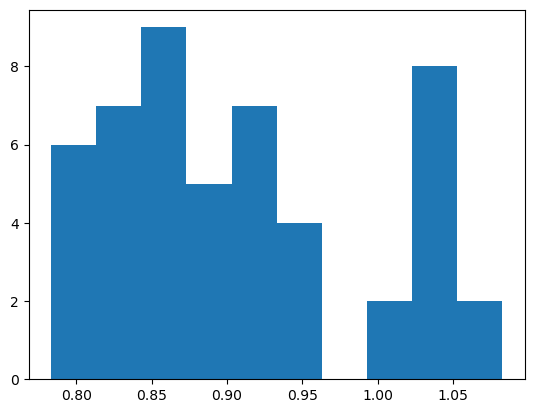

In [68]:
plt.figure()
plt.hist(cutedge_ensemble)
plt.show()